***
# Logistic Regression

A logistic regression model will be implemented to predict whether a student gets admitted into a university. Historical data from previous applicants will be used as a training set. Each training example includes the applicant's scores on two exams and the admissions decision. A classification model that estimates an applicant's
probability of admission based on the scores from those two exams will be built.

Read the data into a pandas dataframe.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

data1 = pd.read_csv('ex2data1.txt', header=None, names=['Score1', 'Score2', 'Admitted'])
data1.head()

Score1     Score2  Admitted
0  34.623660  78.024693         0
1  30.286711  43.894998         0
2  35.847409  72.902198         0
3  60.182599  86.308552         1
4  79.032736  75.344376         1

## Visualizing the Data

Plot the data creating a figure, where the axes are the two exam scores, and the positive and negative examples are shown with different markers.

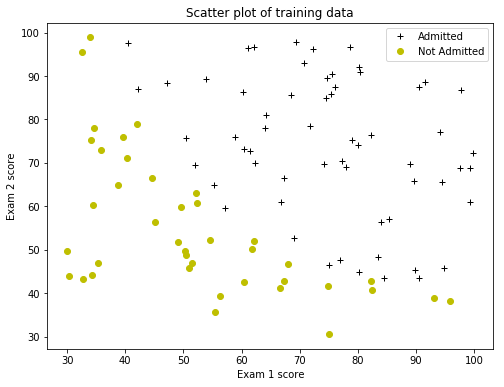

In [2]:
plt.figure(figsize=(8, 6))
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.title('Scatter plot of training data')
plt.plot(data1['Score1'][data1['Admitted']==1],
         data1['Score2'][data1['Admitted']==1], 'k+',
         label='Admitted')
plt.plot(data1['Score1'][data1['Admitted']==0],
         data1['Score2'][data1['Admitted']==0], 'yo',
         label='Not Admitted')
plt.legend()

## Implementation

### Sigmoid Function

The logistic regression hypothesis is defined as:

$h_{\theta}(x) = g(\theta^{T} x)$

where function g is the sigmoid function. The sigmoid function is defined as:

$g(z) = \frac{1}{1+e^{-z}}$

The first step is to implement the sigmoid function. For large positive values of $x$, the sigmoid should be close to 1, while for large negative values, the sigmoid should be close to 0. Evaluating sigmoid(0) should give exactly 0.5. The code should also work with vectors and matrices. For a matrix, the function should perform the sigmoid function on every element.

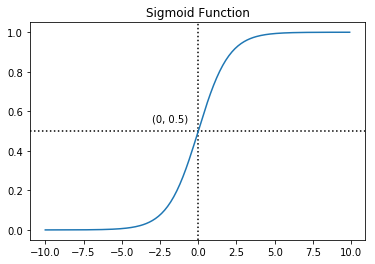

Evaluate sigmoid(0) = 0.5


In [3]:
# Create the sigmoid function.
def sigmoid(z):
    """
    The sigmoid function.
    Args:
        z: float, vector, matrix
    Returns:
        sigmoid: float, vector, matrix
    """
    sigmoid = 1 / (1 + np.exp(-z))
    return sigmoid

# Visualize the sigmoid function
x = np.arange(-10, 10, 0.1)
plt.axhline(y=0.5, c='black', ls=':')
plt.axvline(x=0, c='black', ls=':')
plt.annotate('(0, 0.5)', xy=(0, 0.5), xytext=(-3, 0.55))
plt.plot(x, sigmoid(x))
plt.title('Sigmoid Function')
plt.show()

print('Evaluate sigmoid(0) =', sigmoid(0))

### Cost Function and Gradient

Implement the cost function and gradient for logistic regression. The cost function in logistic regression is:

$J(\theta)=\frac{1}{m} \sum_{i=1}^m[-y^{(i)} log(h_\theta (x^{(i)})-(1-y^{(i)}) log(1-h_\theta (x^{(i)}))]$

and the gradient of the cost is a vector of the same length as $\theta$ where the $j^{th}$ element (for j = 0, 1,..., n) is defined as follows:

$\frac{\partial J(\theta)}{\partial \theta_j}=\frac{1}{m} \sum_{i=1}^m(h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}$

While this gradient looks identical to the linear regression gradient, the formula is actually different because linear and logistic regression have different definitions of $h_{\theta}(x)$.

In [4]:
# Get the number of features.
n = len(data1.columns)-1 # subtract 1 for the target column

# Create a function to pepare the data.
def prepareData(data, n):
    """
    Add 1s column, convert to arrays,
    initialize theta.
    Args:
        data: read the data file
        n: int
    Return:
        x: a (m, n+1) array
        y: a (m, 1) array
        theta: a (n+1, 1) array
    """
    # Add a column with 1s in the data set.
    data.insert(0, 'Ones', 1)

    # Define x and y, separating the data set.
    x = data.iloc[:, 0:n+1]
    y = data.iloc[:, n+1:n+2]

    # Convert to arrays, so this function is
    # compatible with scipy.optimize.fmin later.
    # Initialize parameters theta to 0s.
    # Theta is a (n+1, 1) array,
    # where n is the number of features.
    x = np.array(x.values)
    y = np.array(y.values)
    theta = np.zeros((n+1, 1))
    return x, y, theta

x, y, theta = prepareData(data1, n)

print('Checking the dimensions of the matrices x, y, theta...')
print(x.shape, y.shape, theta.shape)

Checking the dimensions of the matrices x, y, theta...
(100, 3) (100, 1) (3, 1)


In [5]:
# Create a function to compute the cost.
# NOTE!!! The parameters must be in the right order!!!.
# The computeCost(theta, x, y) is the correct order,
# assuming that x and y in computeCost are meant
# to match with the args=(x, y) later in fmin function.
def computeCost(theta, x, y):
    """
    Compute the cost function.
    Args:
        theta: array shape(n+1, 1) 
        x: array shape(m, n+1) 
        y: array shape(m, 1)
    Returns:
        cost: float
    """
    m = len(x)
    # Do matrix multiplication with numpy.dot
    h_theta = sigmoid(np.dot(x, theta))
    term1 = np.dot(-y.T, np.log(h_theta))
    term2 = np.dot((1 - y).T, np.log(1 - h_theta))
    cost = np.sum(term1 - term2) / m
    return cost

print('The cost with initial θ equals to zeros, is:')
print(computeCost(theta, x, y))

The cost with initial θ equals to zeros, is:
0.69314718056


### Learning Parameters Using the `scipy.optimize.fmin` Algorithm

In the previous exercise 1, the optimal parameters of a linear regression model was computed by implementing gradient descent. This time, instead of taking gradient descent steps, a Python function called `fmin` from `scipy` will be used. This is the simplest way to minimize a function (unconstrained and constrained). For logistic regression, the objective is to optimize the cost function $J(\theta)$ with parameters $\theta$. Concretely, `fmin` will be applied to find the best parameters $\theta$ for the logistic regression cost function, given a fixed dataset (of $x$ and $y$ values). The following inputs will be passed to `fmin`:

* The initial values of the parameters to be optimized.
* A function that, when given the training set and a particular $\theta$, computes the logistic regression cost and gradient with respect to $\theta$ for the dataset ($x$, $y$ ).

In [6]:
from scipy.optimize import fmin

def minimizeCost(computeCost, theta, x, y):
    """
    Minimize the cost function.
    Args:
        computeCost: The function to be minimized
        theta: initial guess, array shape(n+1, 1)
        x: array shape(m, n+1)
        y: array shape(m, 1)
    Returns:
        theta: array shape(n+1, 1), the parameters that minimize the cost
    """
    min_cost = fmin(func=computeCost, x0=theta, args=(x, y))
    return min_cost

theta = minimizeCost(computeCost, theta, x, y)

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 157
         Function evaluations: 287


In [7]:
# Print the optimal theta parameters and the cost.
print("Optimal theta parameters:")
print(theta)
print("\nCost of optimal theta:")
print(computeCost(theta, x, y))

Optimal theta parameters:
[-25.16130062   0.20623142   0.20147143]

Cost of optimal theta:
0.20349770159


### Plot the Decision Boundary

Plot the decision boundary on the training data, using the optimal $\theta$ values. The boundary is exactly at sigmoid(0) = 0.5:

$\frac{1}{1+e^{-(\theta_0+\theta_1x_1+\theta_2x_2)}}=0.5$

or

$\theta_0+\theta_1x_1+\theta_2x_2=0$

and with the following conversion

$x_2=-(\frac{\theta_0+\theta_1x_1}{\theta_2})$

the boundary decision is graphically plotted.

### Evaluating logistic regression

Use the model to predict whether a particular student will be admitted. For a student with an Exam 1 score of 45 and an Exam 2 score of 85, it is expected an admission probability of 0.776. Another way to evaluate the quality of the parameters is to see how well the learned model predicts on the training set. Create a predict function that will produce “1” or “0” predictions given a dataset and a learned parameter vector θ. Finally, report the training accuracy of the classifier by computing the percentage of examples it got correct.

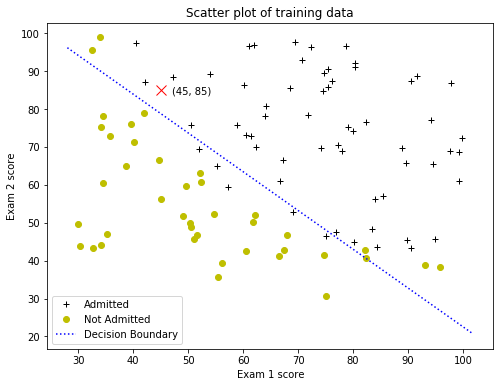

Admission probability for scores (45, 85)= 0.776291590411


In [8]:
# Only 2 points are required to define a line, e.g. min and max.
plot_x = np.array([np.min(x[:, 1]) - 2, np.max(x[:, 1] + 2)])
plot_y = -(theta[0] + theta[1] * plot_x) / theta[2]

plt.figure(figsize=(8, 6))
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.title('Scatter plot of training data')
plt.plot(data1['Score1'][data1['Admitted']==1],
         data1['Score2'][data1['Admitted']==1], 'k+',
         label='Admitted')
plt.plot(data1['Score1'][data1['Admitted']==0],
         data1['Score2'][data1['Admitted']==0], 'yo',
         label='Not Admitted')
plt.plot(plot_x, plot_y, 'b:', label='Decision Boundary')
plt.plot(45, 85, 'rx', ms=10)
plt.annotate('(45, 85)', xy=(45, 85), xytext=(47, 84))
plt.legend()
plt.show()

probability = sigmoid(np.dot(np.array([1, 45, 85]), theta))
print('Admission probability for scores (45, 85)=', probability)

In [9]:
# Create a prediction function.
def predictAdmission(x, theta):
    """
    Predict whether a student will be admitted.
    Args:
        x: array shape(m, n+1)
        theta: ndarray, the optimal parameters of the cost function
    Returns:
        predicted: array shape(m,) of booleans
    """
    probability = np.array(sigmoid(np.dot(x, theta)))
    predicted = probability >= 0.5
    return predicted

predicted = predictAdmission(x, theta)
correct = np.sum(predicted.astype(int) == y.reshape(100))
total = len(predicted)
print('Accuracy score: {}%'.format(100 * correct / total))

Accuracy score: 89.0%


***
# Regularized Logistic Regression

A regularized logistic regression will be implemented to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly. A dataset of test results on past microchips will be used to build a logistic regression model. There are test results for some microchips on two different tests. From these two tests, it will be determined whether the microchips should be accepted or rejected.

Read the data into a pandas dataframe.

In [10]:
data2 = pd.read_csv('ex2data2.txt', header=None, names=['Test1', 'Test2', 'Accepted'])
data2.sample(n=5)

Test1    Test2  Accepted
57  -0.13882 -0.27266         1
4   -0.51325  0.46564         1
12   0.63882 -0.24342         1
112 -0.83007  0.31213         0
40   0.29320 -0.22880         1

## Visualizing the Data

Plot the data creating a figure, where the axes are the two test scores, and the positive ( $y=1$, accepted) and negative ( $y=0$, rejected) examples are shown with different markers.

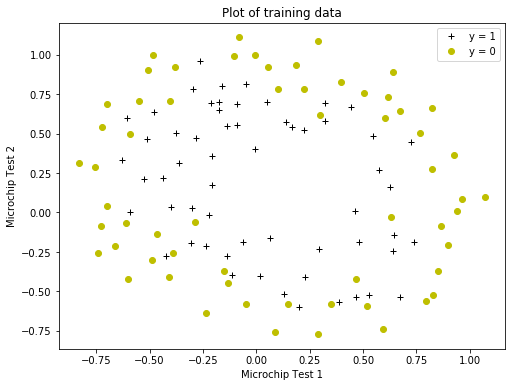

In [11]:
plt.figure(figsize=(8, 6))
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.title('Plot of training data')
plt.plot(data2['Test1'][data2['Accepted']==1],
         data2['Test2'][data2['Accepted']==1], 'k+',
         label='y = 1')
plt.plot(data2['Test1'][data2['Accepted']==0],
         data2['Test2'][data2['Accepted']==0], 'yo',
         label='y = 0')
plt.legend()

The scatter plot shows that the dataset cannot be separated into positive and negative examples by a straight-line through the plot. Therefore, a straightforward application of logistic regression will not perform well on this dataset since logistic regression will only be able to find a linear decision boundary.

## Feature mapping

One way to fit the data better is to create more features from each data point, for example mapping the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power. As a result of this mapping, the matrix of two features (the scores on two QA tests) will be transformed into a 28-dimensional matrix. A logistic regression classifier trained on this higher-dimension feature matrix will have a more complex decision boundary and will appear nonlinear when drawn in the 2-dimensional plot. Note that while the feature mapping allows to build a more expressive classifier, it is also more susceptible to overfitting.

In [12]:
import copy

def mapFeature(data, features, degree):
    """
    Feature mapping function to polynomial features.
    Maps the features to quadratic features.
    Returns a new df with more features, comprising of
    x1, x2, x1^2, x2^2, x1*x2, x1*x2^2, etc...
    Args:
        data: a pandas df with index, features and target cols
        features: int, the number of initial features
        degree: int, the polynomial degree
    Returns:
        df: a pandas df with the new features
    """
    # Create a copy of the data df.
    df = copy.deepcopy(data)
    degree = degree
    # Insert a first column with ones.
    df.insert(0, 'Ones', 1)
    x = []
    for n in range(1, features + 1):
        x.append(df.iloc[:, n])
    for i in range(1, degree + 1):
        for j in range(0, i + 1):
            df['x' + str(i) + str(j)] = np.power(x[0], i-j) * np.power(x[1], j)
    
    # Drop unnecessary columns.
    cols = [0, 1, 2]
    df.drop(df.columns[cols], axis=1, inplace=True)
    # Move target column to the end.
    # Make a list of all of the columns.
    cols = df.columns.tolist()
    # Reorder columns.
    cols = cols[1:] + [cols[0]]
    # Commit the reordering.
    df = df[cols]
    return df

transformed_data = mapFeature(data2, features=2, degree=6)
transformed_data.shape

(118, 28)

## Cost function and gradient

Implement code to compute the cost function and gradient for regularized logistic regression. The regularized cost function in logistic regression is

$J(\theta)=\frac{1}{m} \sum_{i=1}^m[-y^{(i)} log(h_\theta (x^{(i)})-(1-y^{(i)}) log(1-h_\theta (x^{(i)}))]+\frac{\lambda}{2m} \sum_{j=1}^n\theta_j^2$

Note that the parameter $\theta_0$ should not be regularized. The gradient of the cost function is a vector where the $j^{th}$ element is defined as follows:

$\frac{\partial J(\theta)}{\partial \theta_0}=\frac{1}{m} \sum_{i=1}^m(h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}$ for $j=0$

and

$\frac{\partial J(\theta)}{\partial \theta_j}=\frac{1}{m} \sum_{i=1}^m(h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}+\frac{\lambda}{m}\theta_j$ for $j\geq1$

In [13]:
# Get the number of features.
n = len(transformed_data.columns)-1 # subtract the target column

x, y, theta = prepareData(transformed_data, n)

print('Checking the dimensions of the matrices x, y, theta...')
print(x.shape, y.shape, theta.shape)

Checking the dimensions of the matrices x, y, theta...
(118, 28) (118, 1) (28, 1)


In [14]:
# Modify the computeCost function to
# include the regularization term.
def computeCost(theta, x, y, lambda_coef):
    """
    Compute the cost function.
    Args:
        theta: array shape(n+1, 1) 
        x: array shape(m, n+1) 
        y: array shape(m, 1)
        lambda_coef: int
    Returns:
        cost: float
    """
    m = len(x)
    # Do matrix multiplication with numpy.dot
    h_theta = sigmoid(np.dot(x, theta))
    term1 = np.dot(-y.T, np.log(h_theta))
    term2 = np.dot((1 - y).T, np.log(1 - h_theta))
    # Exclude theta_0!!!
    reg_term = (lambda_coef / (2 * m)) * np.sum(np.square(theta[1:]))
    cost = (np.sum(term1 - term2) / m) + reg_term
    return cost

print('The cost with initial θ equals to zeros, is:')
print(computeCost(theta, x, y, 0))

The cost with initial θ equals to zeros, is:
0.69314718056


### Learning Parameters

Similar to the previous parts, an optimize function will be used to learn the optimal parameters $\theta$. The `fmin` was tested and it was found that cannot converge. The alternative `minimize` function will be used.

In [15]:
from scipy.optimize import minimize

res = minimize(fun=computeCost, x0=theta, args=(x, y, 100))
print("Optimal theta parameters for lambda = 100:")
theta_opt = res.x
theta_opt

Optimal theta parameters for lambda = 100:


array([ 0.02188605, -0.01748168,  0.00571031, -0.05516941, -0.01314888,
       -0.03859919, -0.01846354, -0.00773237, -0.00892434, -0.02280491,
       -0.04343876, -0.00235624, -0.01415631, -0.0034951 , -0.04143633,
       -0.02100596, -0.00471923, -0.00359134, -0.00632236, -0.00502442,
       -0.03197706, -0.03416352, -0.00107628, -0.00702623, -0.00038506,
       -0.0079824 , -0.00154778, -0.04108711])

## Plot the Decision Boundary

Plot the decision boundary on the training data, using the optimal $\theta$ values. Compute the classifier’s predictions on an evenly spaced grid and then draw a contour plot of where the predictions change from $y=0$ to $y=1$.

Notice the changes in the decision boundary as $\lambda$ varies. With a small $\lambda$, the classifier gets almost every training example correct, but draws a very complicated boundary, thus overfitting the data. This is not a good decision boundary: for example, it predicts that a point at $x = (−0.25, 1.5)$ is accepted $(y = 1)$, which seems to be an incorrect decision given the training set.

With a larger $\lambda$, the plot shows a simpler decision boundary which still separates the positives and negatives fairly well. However, if $\lambda$ is set too high, the resulting fit is not good and the decision boundary will not follow the data so well, thus underfitting the data.

------------------------------------------------------------

No regularization (Overfitting) (λ = 0)
Accuracy score: 91.5%


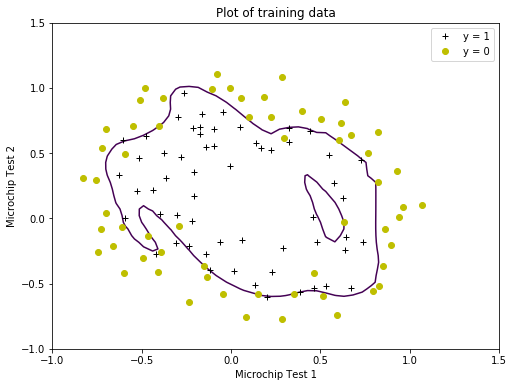

------------------------------------------------------------

Training data with decision boundary (λ = 1)
Accuracy score: 83.1%


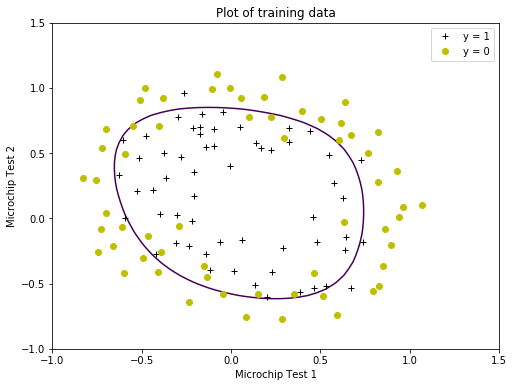

------------------------------------------------------------

Too much regularization (Underfitting) (λ = 100)
Accuracy score: 61.0%


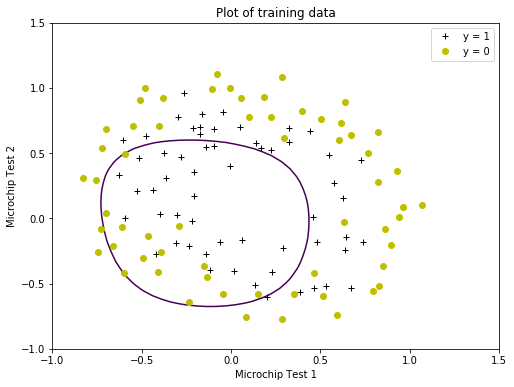

In [16]:
# Create different cases of λ to plot the decision boundaries.
cases = {"No regularization (Overfitting) (λ = 0)": 0,
         "Training data with decision boundary (λ = 1)": 1,
         "Too much regularization (Underfitting) (λ = 100)": 100}

for k, v in cases.items():
    print(60 * "-")
    print()
    print(k)
    
    # Optimize the cost function.
    res = minimize(fun=computeCost, x0=theta, args=(x, y, v))
    theta_opt = res.x
    
    # Compute the accuracy.
    predicted = predictAdmission(x, theta_opt)
    correct = np.sum(predicted.astype(int) == y.ravel())
    total = len(predicted)
    print('Accuracy score: {}%'.format(round((100 * correct / total), 1)))
    
    # Reshape theta to (n, 1).
    theta_opt = theta_opt.reshape(len(theta), 1)

    # Create the meshgrid.
    xs = np.linspace(-1, 1.5, 50)
    ys = np.linspace(-1, 1.5, 50)
    xx, yy = np.meshgrid(xs, ys)
    # Note the input to np.zeros is a tuple!!!
    zs = np.zeros((len(xs), len(ys)))

    # Create the dataframe from the above columns.
    data = pd.DataFrame({'xs': xx.ravel(),
                         'ys': yy.ravel(),
                         'zs': zs.ravel()})

    # Transform the df.
    transformed_data = mapFeature(data, 2, 6)

    # Get the number of features.
    n = len(transformed_data.columns)-1

    # Prepare the data.
    xx1, yy1, theta = prepareData(transformed_data, n)

    # Compute the classifier’s predictions.
    h_theta = sigmoid(np.dot(xx1, theta_opt))
    h_theta = h_theta.reshape((50, 50))

    plt.figure(figsize=(8, 6))
    plt.xlabel('Microchip Test 1')
    plt.ylabel('Microchip Test 2')
    plt.title('Plot of training data')
    plt.plot(data2['Test1'][data2['Accepted']==1],
             data2['Test2'][data2['Accepted']==1], 'k+',
             label='y = 1')
    plt.plot(data2['Test1'][data2['Accepted']==0],
             data2['Test2'][data2['Accepted']==0], 'yo',
             label='y = 0')
    plt.legend()
    plt.contour(xx, yy, h_theta, [0.5])
    plt.show()